In [1]:
# import libraries 
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
import torchvision.transforms as T
from PIL import Image
import os
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# define the CNN model (37-multi classification problem)
# will accept 224 x 224 x 3(RGB) inputs 
# double the conv filters to progressively learn better features (powers of 2 recommended) 
# for fully connected layers, progressively scale down to ultimately get to 37 final layer 

# final feature maps --> 56 channels × 14×14 spatial dimensions

class PetCNN(nn.Module):

    def __init__(self, num_classes = 37):   # inherit from nn module (mandatory for pytorch models)
        super(PetCNN, self).__init__() # initialize super class 

        # create the CNN architecture 
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1) # 3 channels input (RGB), 32 output 
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)

        # Pooling layer
        self.pool = nn.MaxPool2d(2, 2)


        # Fully connected layers
        self.fc1 = nn.Linear(256 * 14 * 14, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)

        # Dropout for regularization
        self.dropout = nn.Dropout(0.3)

        # Activation function
        self.relu = nn.ReLU()

    def forward(self, x):
        # Conv Block 1
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
            
        # Conv Block 2
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
            
        # Conv Block 3
        x = self.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)
            
        # Conv Block 4
        x = self.relu(self.bn4(self.conv4(x)))
        x = self.pool(x)
            
        # Flatten
        x = x.view(-1, 256 * 14 * 14)
            
        # Fully connected layers
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        
        return x
    
        



In [3]:
# custom pytorch dataset class 
# must have __len__ and __getitem__
class PetDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform   # might want to transform the image (resize for one convenient input)
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB') # make sure you convert any greyscale images to 3 channels 
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
            
        return image, label


In [4]:
# Data preparation function
def prepare_data(data_dir):
    """
    Prepare data from Oxford-IIIT Pet Dataset
    Directory structure:
    
    images/
        Abyssinian_1.jpg
        Abyssinian_2.jpg
        ...
    """
    images_dir = os.path.join(data_dir, 'images')
    
    # Get all image files
    image_files = [f for f in os.listdir(images_dir) if f.endswith('.jpg')]
    
    # Extract labels from filenames
    labels = []
    label_to_idx = {}
    idx = 0
    
    for filename in image_files:
        # Extract breed name (everything before the last underscore and number)
        breed = '_'.join(filename.split('_')[:-1])
        
        if breed not in label_to_idx:
            label_to_idx[breed] = idx
            idx += 1
        
        labels.append(label_to_idx[breed])
    
    # Create full paths
    image_paths = [os.path.join(images_dir, f) for f in image_files]
    
    return image_paths, labels, label_to_idx

In [5]:
# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} - Training')
        for images, labels in train_pbar:
            images, labels = images.to(device), labels.to(device)
            
            # clear gradients for each batch 
            optimizer.zero_grad()
            outputs = model(images) # forward pass
            loss = criterion(outputs, labels)   # calculate loss 
            loss.backward()     # backward prop
            optimizer.step()    # update weights 
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            train_pbar.set_postfix({'loss': running_loss/len(train_loader), 
                                   'acc': 100*correct/total})
        
        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct / total
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        
        # Validation phase
        model.eval()        # will stop calculating gradients 
        # reset variables 
        running_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            val_pbar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} - Validation')
            for images, labels in val_pbar:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
                val_pbar.set_postfix({'loss': running_loss/len(val_loader), 
                                     'acc': 100*correct/total})
        
        
        val_loss = running_loss / len(val_loader)
        val_acc = 100 * correct / total
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        print(f'Epoch [{epoch+1}/{num_epochs}]')
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
        print('-' * 50)
    
    return train_losses, train_accs, val_losses, val_accs

In [6]:
# Visualization function
def plot_training_history(train_losses, train_accs, val_losses, val_accs):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    # Loss plot
    ax1.plot(train_losses, label='Train Loss')
    ax1.plot(val_losses, label='Val Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.legend()
    ax1.grid(True)
    
    # Accuracy plot
    ax2.plot(train_accs, label='Train Acc')
    ax2.plot(val_accs, label='Val Acc')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.set_title('Training and Validation Accuracy')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

In [7]:
# Main training script
def main():
    # Configuration
    data_dir = ''                               ###### PATH (just make sure the folder images is in the same dir as the py file)
    batch_size = 32
    num_epochs = 30 
    learning_rate = 0.001
    image_size = 224
    
    # Check for GPU/MPS
    if torch.cuda.is_available():
        device = torch.device('cuda')
    elif torch.backends.mps.is_available():
        device = torch.device('mps')
    else:
        device = torch.device('cpu')
    print(f'Using device: {device}')
    
    # Data transforms
    train_transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    val_transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # Prepare data
    print('Loading dataset...')
    image_paths, labels, label_to_idx = prepare_data(data_dir)
    num_classes = len(label_to_idx)
    print(f'Found {num_classes} pet breeds')
    
    # Split data
    train_paths, val_paths, train_labels, val_labels = train_test_split(
        image_paths, labels, test_size=0.2, random_state=42, stratify=labels
    )
    
    # Create datasets
    train_dataset = PetDataset(train_paths, train_labels, transform=train_transform)
    val_dataset = PetDataset(val_paths, val_labels, transform=val_transform)
    
    # Create data loaders
    # Note: For MPS, you might need to reduce num_workers or set it to 0
    num_workers = 0 if device.type == 'mps' else 4
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    
    # Initialize model
    model = PetCNN(num_classes=num_classes).to(device)
    
    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # Train model
    print('Starting training...')
    train_losses, train_accs, val_losses, val_accs = train_model(
        model, train_loader, val_loader, criterion, optimizer, num_epochs, device
    )
    
    # Plot results
    plot_training_history(train_losses, train_accs, val_losses, val_accs)
    
    # Save model
    torch.save({
        'model_state_dict': model.state_dict(),
        'label_to_idx': label_to_idx,
        'num_classes': num_classes
    }, 'pet_classifier_model.pth')
    print('Model saved as pet_classifier_model.pth')
    
    return model, label_to_idx

In [8]:
# Inference function
def predict_image(model, image_path, transform, label_to_idx, device):
    """
    Predict the breed of a single pet image
    """
    model.eval()
    
    # Load and transform image
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)
    
    # Get prediction
    with torch.no_grad():
        outputs = model(image_tensor)
        _, predicted = torch.max(outputs, 1)
        
    # Get breed name
    idx_to_label = {v: k for k, v in label_to_idx.items()}
    breed = idx_to_label[predicted.item()]
    
    # Get confidence scores
    probabilities = torch.nn.functional.softmax(outputs, dim=1)
    confidence = probabilities[0][predicted].item()
    
    return breed, confidence

Using device: mps
Loading dataset...
Found 37 pet breeds
Starting training...


Epoch 1/30 - Validation: 100%|██████████| 47/47 [00:05<00:00,  8.00it/s, loss=3.59, acc=5.48] 


Epoch [1/30]
Train Loss: 3.9892, Train Acc: 3.30%
Val Loss: 3.5869, Val Acc: 5.48%
--------------------------------------------------


Epoch 2/30 - Validation: 100%|██████████| 47/47 [00:06<00:00,  7.61it/s, loss=3.54, acc=5.82] 


Epoch [2/30]
Train Loss: 3.5422, Train Acc: 4.97%
Val Loss: 3.5433, Val Acc: 5.82%
--------------------------------------------------


Epoch 3/30 - Validation: 100%|██████████| 47/47 [00:06<00:00,  7.74it/s, loss=3.46, acc=6.02] 


Epoch [3/30]
Train Loss: 3.4811, Train Acc: 5.67%
Val Loss: 3.4573, Val Acc: 6.02%
--------------------------------------------------


Epoch 4/30 - Validation: 100%|██████████| 47/47 [00:05<00:00,  7.92it/s, loss=3.34, acc=8.93] 


Epoch [4/30]
Train Loss: 3.4363, Train Acc: 6.26%
Val Loss: 3.3436, Val Acc: 8.93%
--------------------------------------------------


Epoch 5/30 - Validation: 100%|██████████| 47/47 [00:06<00:00,  7.08it/s, loss=3.28, acc=10.2] 


Epoch [5/30]
Train Loss: 3.3910, Train Acc: 6.95%
Val Loss: 3.2818, Val Acc: 10.22%
--------------------------------------------------


Epoch 6/30 - Validation: 100%|██████████| 47/47 [00:06<00:00,  7.74it/s, loss=3.29, acc=10.8] 


Epoch [6/30]
Train Loss: 3.3753, Train Acc: 7.73%
Val Loss: 3.2852, Val Acc: 10.76%
--------------------------------------------------


Epoch 7/30 - Validation: 100%|██████████| 47/47 [00:06<00:00,  7.66it/s, loss=3.3, acc=9.13]  


Epoch [7/30]
Train Loss: 3.3430, Train Acc: 7.98%
Val Loss: 3.3049, Val Acc: 9.13%
--------------------------------------------------


Epoch 8/30 - Validation: 100%|██████████| 47/47 [00:06<00:00,  7.59it/s, loss=3.28, acc=10.4] 


Epoch [8/30]
Train Loss: 3.3088, Train Acc: 9.39%
Val Loss: 3.2757, Val Acc: 10.35%
--------------------------------------------------


Epoch 9/30 - Validation: 100%|██████████| 47/47 [00:05<00:00,  7.93it/s, loss=3.44, acc=7.44] 


Epoch [9/30]
Train Loss: 3.3048, Train Acc: 8.56%
Val Loss: 3.4442, Val Acc: 7.44%
--------------------------------------------------


Epoch 10/30 - Validation: 100%|██████████| 47/47 [00:06<00:00,  7.73it/s, loss=3.22, acc=11.3] 


Epoch [10/30]
Train Loss: 3.2768, Train Acc: 9.03%
Val Loss: 3.2226, Val Acc: 11.30%
--------------------------------------------------


Epoch 11/30 - Validation: 100%|██████████| 47/47 [02:55<00:00,  3.73s/it, loss=3.22, acc=11]   


Epoch [11/30]
Train Loss: 3.2735, Train Acc: 9.74%
Val Loss: 3.2231, Val Acc: 11.03%
--------------------------------------------------


Epoch 12/30 - Validation: 100%|██████████| 47/47 [00:05<00:00,  8.05it/s, loss=3.22, acc=12.2] 


Epoch [12/30]
Train Loss: 3.2608, Train Acc: 9.96%
Val Loss: 3.2150, Val Acc: 12.25%
--------------------------------------------------


Epoch 13/30 - Validation: 100%|██████████| 47/47 [00:06<00:00,  7.32it/s, loss=3.16, acc=11.6] 


Epoch [13/30]
Train Loss: 3.2592, Train Acc: 9.66%
Val Loss: 3.1620, Val Acc: 11.57%
--------------------------------------------------


Epoch 14/30 - Validation: 100%|██████████| 47/47 [00:06<00:00,  7.67it/s, loss=3.16, acc=12.5] 


Epoch [14/30]
Train Loss: 3.2246, Train Acc: 10.77%
Val Loss: 3.1634, Val Acc: 12.52%
--------------------------------------------------


Epoch 15/30 - Validation: 100%|██████████| 47/47 [00:06<00:00,  7.17it/s, loss=3.19, acc=11.9] 


Epoch [15/30]
Train Loss: 3.2203, Train Acc: 10.99%
Val Loss: 3.1943, Val Acc: 11.91%
--------------------------------------------------


Epoch 16/30 - Validation: 100%|██████████| 47/47 [00:06<00:00,  7.43it/s, loss=3.35, acc=9.13] 


Epoch [16/30]
Train Loss: 3.1936, Train Acc: 11.10%
Val Loss: 3.3472, Val Acc: 9.13%
--------------------------------------------------


Epoch 17/30 - Validation: 100%|██████████| 47/47 [00:06<00:00,  7.50it/s, loss=3.27, acc=11.9] 


Epoch [17/30]
Train Loss: 3.1790, Train Acc: 10.96%
Val Loss: 3.2700, Val Acc: 11.91%
--------------------------------------------------


Epoch 18/30 - Validation: 100%|██████████| 47/47 [00:06<00:00,  7.43it/s, loss=3.18, acc=12.5] 


Epoch [18/30]
Train Loss: 3.1462, Train Acc: 12.21%
Val Loss: 3.1769, Val Acc: 12.52%
--------------------------------------------------


Epoch 19/30 - Validation: 100%|██████████| 47/47 [00:06<00:00,  7.66it/s, loss=3.04, acc=16]   


Epoch [19/30]
Train Loss: 3.1240, Train Acc: 12.16%
Val Loss: 3.0401, Val Acc: 16.04%
--------------------------------------------------


Epoch 20/30 - Validation: 100%|██████████| 47/47 [00:06<00:00,  7.61it/s, loss=3.02, acc=15.9] 


Epoch [20/30]
Train Loss: 3.0968, Train Acc: 13.48%
Val Loss: 3.0151, Val Acc: 15.90%
--------------------------------------------------


Epoch 21/30 - Validation: 100%|██████████| 47/47 [00:06<00:00,  7.18it/s, loss=3.08, acc=15.8] 


Epoch [21/30]
Train Loss: 3.0697, Train Acc: 13.75%
Val Loss: 3.0846, Val Acc: 15.83%
--------------------------------------------------


Epoch 22/30 - Validation: 100%|██████████| 47/47 [00:06<00:00,  7.70it/s, loss=3, acc=19.2]    


Epoch [22/30]
Train Loss: 3.0476, Train Acc: 14.41%
Val Loss: 2.9957, Val Acc: 19.22%
--------------------------------------------------


Epoch 23/30 - Validation: 100%|██████████| 47/47 [00:06<00:00,  7.12it/s, loss=2.97, acc=16.7] 


Epoch [23/30]
Train Loss: 3.0157, Train Acc: 14.26%
Val Loss: 2.9737, Val Acc: 16.71%
--------------------------------------------------


Epoch 24/30 - Validation: 100%|██████████| 47/47 [00:06<00:00,  7.66it/s, loss=2.9, acc=19.1]  


Epoch [24/30]
Train Loss: 3.0050, Train Acc: 14.94%
Val Loss: 2.8969, Val Acc: 19.08%
--------------------------------------------------


Epoch 25/30 - Validation: 100%|██████████| 47/47 [00:06<00:00,  7.45it/s, loss=2.9, acc=20.6]  


Epoch [25/30]
Train Loss: 2.9557, Train Acc: 14.87%
Val Loss: 2.9024, Val Acc: 20.57%
--------------------------------------------------


Epoch 26/30 - Validation: 100%|██████████| 47/47 [00:06<00:00,  7.48it/s, loss=2.96, acc=17.9] 


Epoch [26/30]
Train Loss: 2.9537, Train Acc: 15.31%
Val Loss: 2.9608, Val Acc: 17.86%
--------------------------------------------------


Epoch 27/30 - Validation: 100%|██████████| 47/47 [00:05<00:00,  7.94it/s, loss=2.88, acc=22]   


Epoch [27/30]
Train Loss: 2.9365, Train Acc: 15.71%
Val Loss: 2.8808, Val Acc: 21.99%
--------------------------------------------------


Epoch 28/30 - Validation: 100%|██████████| 47/47 [00:05<00:00,  7.92it/s, loss=2.83, acc=20]   


Epoch [28/30]
Train Loss: 2.9026, Train Acc: 16.85%
Val Loss: 2.8275, Val Acc: 20.03%
--------------------------------------------------


Epoch 29/30 - Validation: 100%|██████████| 47/47 [00:05<00:00,  7.85it/s, loss=2.81, acc=21.5] 


Epoch [29/30]
Train Loss: 2.8559, Train Acc: 17.69%
Val Loss: 2.8074, Val Acc: 21.52%
--------------------------------------------------


Epoch 30/30 - Validation: 100%|██████████| 47/47 [00:05<00:00,  7.97it/s, loss=2.75, acc=22.7] 


Epoch [30/30]
Train Loss: 2.8628, Train Acc: 17.37%
Val Loss: 2.7494, Val Acc: 22.67%
--------------------------------------------------


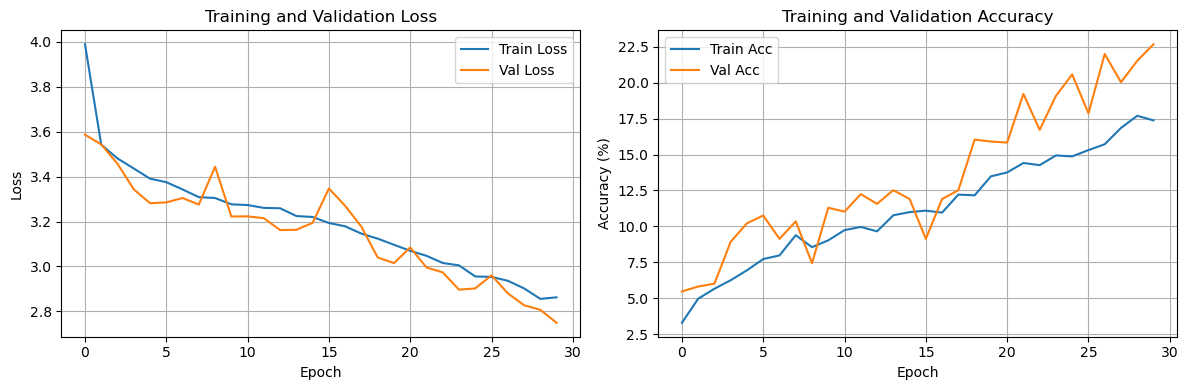

Model saved as pet_classifier_model.pth


(PetCNN(
   (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   (fc1): Linear(in_features=50176, out_features=512, bias=True)
   (fc2): Linear(in_features=512, out_features=256, bias=True)
   (fc3): Linear(in_features=256, out_features=37, bias=True)
   (dropout): Dropout(p=0.3, inplace=Fa

In [9]:
# run the cnn model 
main()

# Testing Pre-trained models

In [10]:
# let's implement (Transfer Learning)
def ResNet50(num_classes):
    """
    Create a model using transfer learning with ResNet50
    """
    model = models.resnet50(pretrained=True)
    
    # Freeze early layers
    for param in model.parameters():
        param.requires_grad = False
    
    # Replace the final layer
    num_features = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Linear(num_features, 512),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(512, num_classes)
    )
    
    return model

In [11]:
# rerun main but with ResNet 

def main():
    # Configuration
    data_dir = ''                               ###### PATH (just make sure the folder images is in the same dir as the py file)
    batch_size = 32
    num_epochs = 15
    learning_rate = 0.001
    image_size = 224
    
    # Check for GPU/MPS
    if torch.cuda.is_available():
        device = torch.device('cuda')
    elif torch.backends.mps.is_available():
        device = torch.device('mps')
    else:
        device = torch.device('cpu')
    print(f'Using device: {device}')
    
    # Data transforms
    train_transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    val_transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # Prepare data
    print('Loading dataset...')
    image_paths, labels, label_to_idx = prepare_data(data_dir)
    num_classes = len(label_to_idx)
    print(f'Found {num_classes} pet breeds')
    
    # Split data
    train_paths, val_paths, train_labels, val_labels = train_test_split(
        image_paths, labels, test_size=0.2, random_state=42, stratify=labels
    )
    
    # Create datasets
    train_dataset = PetDataset(train_paths, train_labels, transform=train_transform)
    val_dataset = PetDataset(val_paths, val_labels, transform=val_transform)
    
    # Create data loaders
    # Note: For MPS, you might need to reduce num_workers or set it to 0
    num_workers = 0 if device.type == 'mps' else 4
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    
    # Initialize model
    model = ResNet50(num_classes).to(device)
    
    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # Train model
    print('Starting training...')
    train_losses, train_accs, val_losses, val_accs = train_model(
        model, train_loader, val_loader, criterion, optimizer, num_epochs, device
    )
    
    # Plot results
    plot_training_history(train_losses, train_accs, val_losses, val_accs)
    
    # Save model
    torch.save({
        'model_state_dict': model.state_dict(),
        'label_to_idx': label_to_idx,
        'num_classes': num_classes
    }, 'pet_classifier_model.pth')
    print('Model saved as ResNetTuned.pth')
    
    return model, label_to_idx

Using device: mps
Loading dataset...
Found 37 pet breeds


/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /Users/narengarapati/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:02<00:00, 42.5MB/s]


Starting training...


Epoch 1/15 - Validation: 100%|██████████| 47/47 [00:11<00:00,  3.99it/s, loss=0.491, acc=85.4] 


Epoch [1/15]
Train Loss: 1.5805, Train Acc: 55.97%
Val Loss: 0.4906, Val Acc: 85.39%
--------------------------------------------------


Epoch 2/15 - Validation: 100%|██████████| 47/47 [00:11<00:00,  4.08it/s, loss=0.361, acc=89]   


Epoch [2/15]
Train Loss: 0.6822, Train Acc: 77.64%
Val Loss: 0.3613, Val Acc: 88.97%
--------------------------------------------------


Epoch 3/15 - Validation: 100%|██████████| 47/47 [00:10<00:00,  4.28it/s, loss=0.339, acc=89]   


Epoch [3/15]
Train Loss: 0.6018, Train Acc: 80.48%
Val Loss: 0.3394, Val Acc: 88.97%
--------------------------------------------------


Epoch 4/15 - Validation: 100%|██████████| 47/47 [00:11<00:00,  4.14it/s, loss=0.336, acc=89.5] 


Epoch [4/15]
Train Loss: 0.5476, Train Acc: 82.29%
Val Loss: 0.3359, Val Acc: 89.51%
--------------------------------------------------


Epoch 5/15 - Validation: 100%|██████████| 47/47 [00:11<00:00,  4.26it/s, loss=0.382, acc=87.4] 


Epoch [5/15]
Train Loss: 0.5323, Train Acc: 81.88%
Val Loss: 0.3821, Val Acc: 87.42%
--------------------------------------------------


Epoch 6/15 - Validation: 100%|██████████| 47/47 [00:11<00:00,  4.24it/s, loss=0.326, acc=89.8] 


Epoch [6/15]
Train Loss: 0.4992, Train Acc: 82.93%
Val Loss: 0.3257, Val Acc: 89.78%
--------------------------------------------------


Epoch 7/15 - Validation: 100%|██████████| 47/47 [00:10<00:00,  4.45it/s, loss=0.335, acc=88.9] 


Epoch [7/15]
Train Loss: 0.5015, Train Acc: 83.24%
Val Loss: 0.3349, Val Acc: 88.90%
--------------------------------------------------


Epoch 8/15 - Validation: 100%|██████████| 47/47 [00:10<00:00,  4.39it/s, loss=0.347, acc=87.7] 


Epoch [8/15]
Train Loss: 0.4978, Train Acc: 83.56%
Val Loss: 0.3467, Val Acc: 87.69%
--------------------------------------------------


Epoch 9/15 - Validation: 100%|██████████| 47/47 [00:10<00:00,  4.29it/s, loss=0.327, acc=89]   


Epoch [9/15]
Train Loss: 0.4921, Train Acc: 83.49%
Val Loss: 0.3268, Val Acc: 89.04%
--------------------------------------------------


Epoch 10/15 - Validation: 100%|██████████| 47/47 [00:10<00:00,  4.46it/s, loss=0.332, acc=88.9] 


Epoch [10/15]
Train Loss: 0.4803, Train Acc: 83.64%
Val Loss: 0.3320, Val Acc: 88.90%
--------------------------------------------------


Epoch 11/15 - Validation: 100%|██████████| 47/47 [00:10<00:00,  4.53it/s, loss=0.326, acc=90]   


Epoch [11/15]
Train Loss: 0.4653, Train Acc: 84.62%
Val Loss: 0.3259, Val Acc: 89.99%
--------------------------------------------------


Epoch 12/15 - Validation: 100%|██████████| 47/47 [00:10<00:00,  4.35it/s, loss=0.344, acc=89.1] 


Epoch [12/15]
Train Loss: 0.4838, Train Acc: 84.13%
Val Loss: 0.3441, Val Acc: 89.11%
--------------------------------------------------


Epoch 13/15 - Validation: 100%|██████████| 47/47 [00:11<00:00,  4.21it/s, loss=0.379, acc=87.8] 


Epoch [13/15]
Train Loss: 0.4284, Train Acc: 85.86%
Val Loss: 0.3785, Val Acc: 87.82%
--------------------------------------------------


Epoch 14/15 - Validation: 100%|██████████| 47/47 [00:10<00:00,  4.38it/s, loss=0.309, acc=90.5] 


Epoch [14/15]
Train Loss: 0.4246, Train Acc: 85.37%
Val Loss: 0.3090, Val Acc: 90.46%
--------------------------------------------------


Epoch 15/15 - Validation: 100%|██████████| 47/47 [00:11<00:00,  4.21it/s, loss=0.332, acc=88.8] 


Epoch [15/15]
Train Loss: 0.4397, Train Acc: 85.33%
Val Loss: 0.3318, Val Acc: 88.77%
--------------------------------------------------


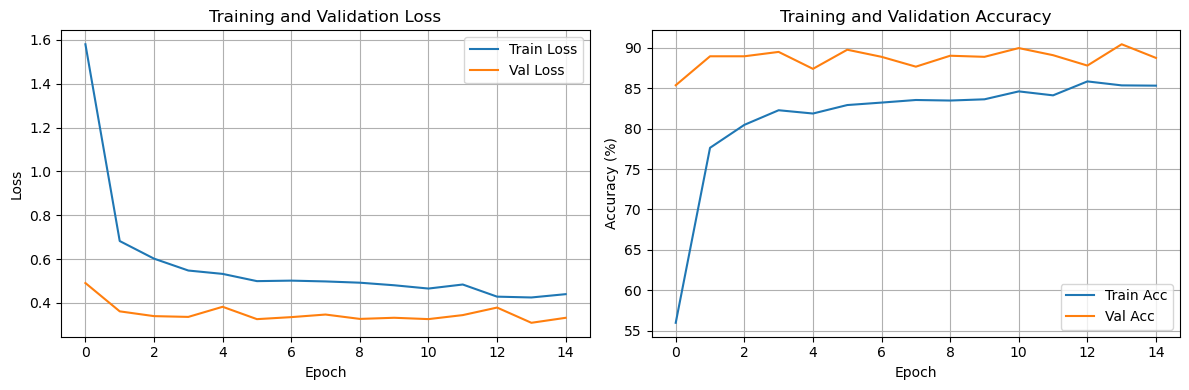

Model saved as ResNetTuned.pth


(ResNet(
   (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
   (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (relu): ReLU(inplace=True)
   (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
   (layer1): Sequential(
     (0): Bottleneck(
       (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
       (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
       (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (relu): ReLU(inplace=True)
       (downsample): Sequential(
         (0): Conv2d(64, 256, kernel_size=(1,

In [12]:
main()